In [1]:
!pip install -q transformers
!pip install -q twython

## Sentiment Analysis in Python

Sentiment analysis is a powerful tool for understanding the emotions expressed in textual data. It is widely used in applications such as customer feedback analysis, social media monitoring, product reviews, and more. By identifying whether a text is positive, negative, or neutral, businesses and organizations can gain valuable insights into public opinion, improve customer experiences, and make informed decisions.

In this exploration of sentiment analysis in Python, we will leverage two popular techniques:

1. **VADER (Valence Aware Dictionary and Sentiment Reasoning)**: VADER is a rule-based sentiment analysis tool designed to handle social media text. It uses a "bag of words" approach, which involves scoring individual words and combining them to produce an overall sentiment score. VADER is simple, fast, and effective for basic sentiment analysis, making it ideal for applications with a limited context.

2. **RoBERTa (Robustly Optimized BERT Pretraining Approach)**: RoBERTa is a pretrained transformer model that excels in understanding the context of words within sentences. Unlike VADER, which analyzes words individually, RoBERTa considers the relationship between words, providing a more nuanced understanding of sentiment. This model can handle complex linguistic structures, including sarcasm, negation, and context-dependent meanings, making it well-suited for sophisticated sentiment analysis tasks.

We will compare the results of these two methods to see how they perform on a dataset of customer reviews, gaining insight into the strengths and limitations of each approach. By the end of this analysis, we’ll have a better understanding of how to apply sentiment analysis in Python to real-world data, enabling us to choose the best tool for different sentiment-related tasks.


## Step 1: Read in Data and NLTK Basics

In the first step, we load a dataset of customer reviews, which serves as the foundation for our sentiment analysis. By reading in this data, we prepare it for further exploration and processing. After loading, we perform a basic inspection to understand its structure, including the number of rows and columns and a quick view of the data itself. This initial exploration helps to confirm that the data is loaded correctly and provides insight into the types of information we’ll be working with, such as review text and rating scores.

With the data loaded, we then introduce **NLTK (Natural Language Toolkit)**, a powerful library for text processing in Python. NLTK provides tools for tokenizing text (splitting it into individual words), part-of-speech (POS) tagging, and other essential text manipulation tasks. By tokenizing a sample review, we can begin examining the text at a granular level, allowing us to understand the structure of individual words and their roles in sentences. 

We also explore POS tagging, which labels each word with its grammatical role (such as noun, verb, adjective, etc.). This step is essential because certain parts of speech, like adjectives and adverbs, often carry sentiment and can be critical in sentiment analysis. By understanding the basics of NLTK, we set the stage for more sophisticated text processing techniques in later steps.


In [2]:
# Load Libraries
import numpy as np                     # For numerical operations
import pandas as pd                    # For data manipulation
import seaborn as sns                  # For data visualization
import matplotlib.pyplot as plt        # For plotting
from tqdm.notebook import tqdm         # For progress tracking in loops
import torch                           # For device management (CPU/GPU)
from scipy.special import softmax      # For softmax normalization in model output
import nltk                            # For Natural Language Processing
from nltk.sentiment import SentimentIntensityAnalyzer  # For VADER sentiment analysis
from transformers import AutoTokenizer, AutoModelForSequenceClassification  # For RoBERTa sentiment analysis
import warnings

# Set plotting style for better visuals
plt.style.use('ggplot')

# Initialize the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

In [3]:
# Load dataset
df = pd.read_csv('/kaggle/input/amazon-fine-food-reviews/Reviews.csv')
print(df.shape)

# Limit DataFrame to 500
df = df.head(500)
print(df.shape)

(568454, 10)
(500, 10)


In [4]:
# Load head data
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
# Load tail data
df.tail()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
495,496,B000G6RYNE,APGAA43E3WPN7,Darren,0,0,5,1201392000,amazing chips,i rarely eat chips but i saw these and tried t...
496,497,B000G6RYNE,ABR7HU5H1KNE,Keith,0,0,5,1196726400,Best Chip Ever,This is easily the best potato chip that I hav...
497,498,B000G6RYNE,AJQD2WWJYOYFQ,bubbles,0,0,4,1186617600,"Tangy, spicy, and sweet- oh my!",Kettle Chips Spicy Thai potato chips have the ...
498,499,B000G6RYNE,A16YH487W9ZYO0,Bruce G. Lindsay,0,0,4,1184198400,An indulgence with a bite,"Okay, I should not eat potato chips, nor shoul..."
499,500,B000G6RYNE,A83YQC1XOU4CS,J. Baker,0,0,5,1183420800,The best I've had,I don't write very many reviews but I have to ...


### Quick EDA (Exploratory Data Analysis)

In this quick EDA, we examine the distribution of review scores in the dataset to gain an initial understanding of customer sentiment trends. Visualizing the count and proportion of each star rating (from 1 to 5 stars) provides insights into how customers generally perceive the product or service being reviewed.

### 1. Bar Chart for Count of Reviews by Star Rating

The bar chart shows the total count of reviews for each star rating, accompanied by percentage annotations to indicate each rating’s relative share in the dataset. This allows us to quickly assess whether certain ratings are more common than others, revealing any bias or trend in customer feedback. For example, a higher concentration of 5-star ratings would suggest a generally positive sentiment, while an abundance of 1-star reviews might indicate dissatisfaction.

This visualization is especially useful in understanding the overall distribution and identifying whether the data skews towards positive or negative sentiment. Adding both counts and percentages enhances interpretability, providing both absolute and relative perspectives on the distribution of scores.

### 2. Pie Chart for Percentage Distribution of Review Scores

The pie chart presents the percentage distribution of each star rating, giving a visual breakdown of their relative frequencies. The "explode" effect is applied to the most common rating, making it stand out for easier identification. This chart provides an intuitive snapshot of the sentiment spread across different review scores, enabling quick identification of the predominant sentiment.

By observing the proportions of each rating in a pie format, we can immediately see whether the reviews are mostly positive, negative, or evenly distributed. This helps lay the foundation for further analysis, as understanding the general sentiment distribution is crucial for contextualizing subsequent insights from sentiment analysis.

Together, these visualizations provide a comprehensive overview of the dataset’s sentiment structure, helping us identify key patterns in customer feedback before diving into more detailed analysis.

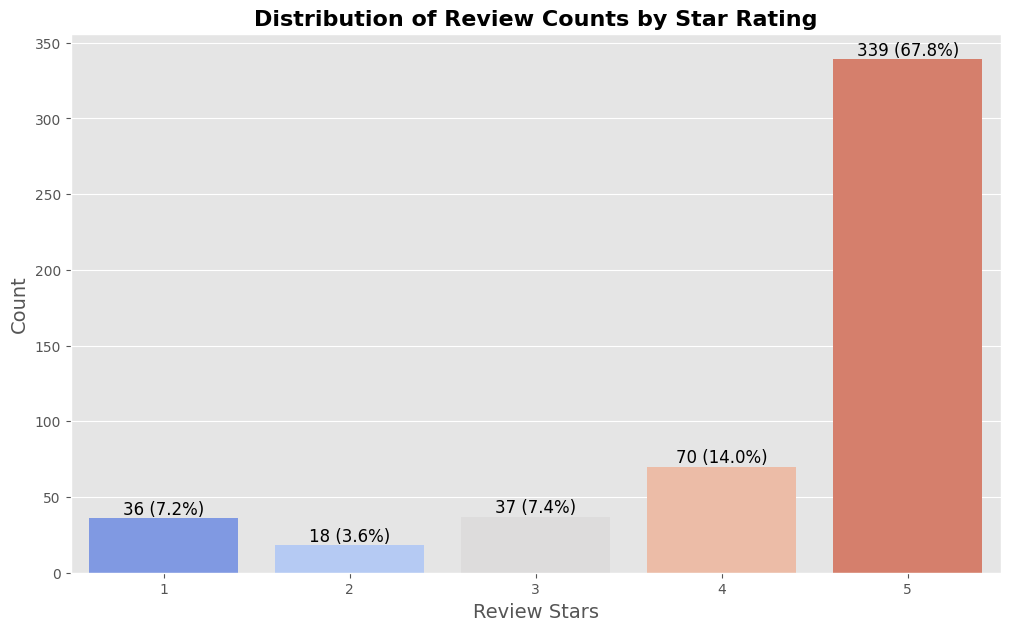

In [6]:
# Set plot size and style
plt.figure(figsize=(12, 7))

# Create the bar plot with better color palette and annotations
ax = sns.countplot(x='Score', data=df, palette='coolwarm', order=sorted(df['Score'].unique()))
ax.set_title('Distribution of Review Counts by Star Rating', fontsize=16, weight='bold')
ax.set_xlabel('Review Stars', fontsize=14)
ax.set_ylabel('Count', fontsize=14)

# Add annotations with whole number count and percentage to 1 decimal place
total_reviews = len(df)
for p in ax.patches:
    count = int(p.get_height())
    percentage = f'{100 * count / total_reviews:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = count
    ax.annotate(f'{count} ({percentage})', (x, y), ha='center', va='bottom', fontsize=12, color='black')

# Show the plot
plt.show()

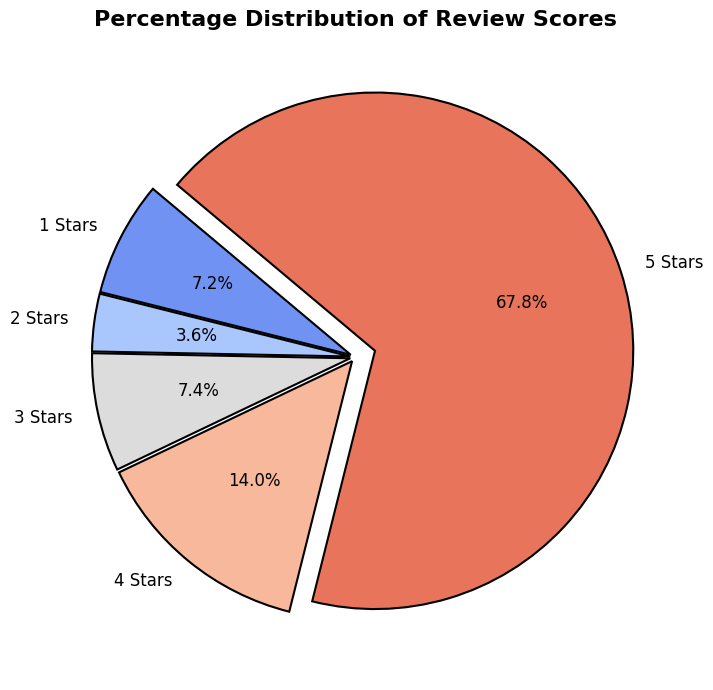

In [7]:
# Set up the figure
plt.figure(figsize=(12, 7))

# Get score counts and configure explode for the most common rating
score_counts = df['Score'].value_counts().sort_index()
explode = [0.08 if i == score_counts.idxmax() else 0.02 for i in score_counts.index]  # Slightly explode all segments, with max more

# Create the pie chart with customizations
plt.pie(
    score_counts, 
    labels=[f'{label} Stars' for label in score_counts.index],  # Adding 'Stars' for clarity
    autopct='%1.1f%%', 
    startangle=140, 
    colors=sns.color_palette('coolwarm', len(score_counts)), 
    explode=explode, 
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5},  # Emphasize separation with edge color
    textprops={'fontsize': 12}  # Larger font for readability
)

# Title with improved formatting
plt.title('Percentage Distribution of Review Scores', fontsize=16, weight='bold')

# Show the plot
plt.tight_layout()
plt.show()

### Introduction to NLTK and Basic Text Processing

**NLTK (Natural Language Toolkit)** is a powerful Python library for natural language processing (NLP). It provides a wide range of tools for handling and analyzing human language data, including tokenization, part-of-speech tagging, stemming, lemmatization, and parsing. NLTK is particularly useful for transforming raw text into structured data, making it a popular choice for text analysis tasks.

### Explanation of the Process:

1. **Extracting a Sample Review**:
   A specific review is selected from the dataset to serve as an example for text processing. This review allows us to explore the application of NLTK functions on real-world text data and observe the transformation from raw text to individual components.

2. **Tokenization**:
   The process of tokenization is used to break down the review text into individual words or symbols, called tokens. Tokenization is essential in NLP as it divides continuous text into discrete elements that can be analyzed independently. Each word, punctuation mark, or symbol becomes a separate token, allowing for further processing, such as word counting, sentiment analysis, and part-of-speech tagging. For example, the sentence "The food was excellent!" would be tokenized into ["The", "food", "was", "excellent", "!"].

3. **Inspecting Tokens**:
   After tokenization, a subset of tokens is examined to verify the results. This inspection step helps ensure that the text was correctly split into tokens and allows us to observe the structure of the text data at a granular level. By examining the tokens, we can confirm that tokenization was successful and that the text is now ready for more advanced NLP tasks.

### Importance of Tokenization in NLP

Tokenization is a crucial step in preparing text data for analysis, as it enables us to:
- Analyze word frequency and patterns.
- Identify and isolate specific keywords.
- Perform syntactic and semantic analysis, such as part-of-speech tagging and sentiment analysis.
- Work with individual tokens independently, facilitating structured and meaningful analysis of unstructured text.

This initial processing step with NLTK is foundational for any NLP project, as it converts raw text into a manageable format, setting the stage for deeper analysis.

In [8]:
# This line selects a specific review from the dataset, here the 50th row in the "Text" column.
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [9]:
# Tokenization
# Using NLTK's word_tokenize function, the text is split into individual tokens (words and punctuation).
token = nltk.word_tokenize(example)

# Displaying Tokens
# Displaying the first 10 tokens to verify the tokenization result.
print(token[:10])

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']


### NLTK POS (Part-of-Speech) Tag List

In Natural Language Processing (NLP), part-of-speech tagging assigns labels to each word in a sentence to indicate its grammatical role. NLTK provides a list of POS tags that helps categorize each word type, which is essential for understanding sentence structure and meaning. Below is a list of common POS tags in NLTK:

- **CC**: Coordinating conjunction (e.g., "and," "but")
- **CD**: Cardinal digit (e.g., "one," "2")
- **DT**: Determiner (e.g., "the," "a")
- **EX**: Existential "there" (e.g., "There is")
- **FW**: Foreign word
- **IN**: Preposition or subordinating conjunction (e.g., "in," "of")
- **JJ**: Adjective (e.g., "good," "blue")
- **JJR**: Comparative adjective (e.g., "better," "bigger")
- **JJS**: Superlative adjective (e.g., "best," "biggest")
- **LS**: List marker
- **MD**: Modal verb (e.g., "can," "will")
- **NN**: Singular noun (e.g., "dog," "city")
- **NNS**: Plural noun (e.g., "dogs," "cities")
- **NNP**: Proper noun, singular (e.g., "John," "London")
- **NNPS**: Proper noun, plural (e.g., "Americans")
- **PDT**: Predeterminer (e.g., "all," "both")
- **WRB**: Wh-adverb (e.g., "how," "where")
- **WP$**: Possessive wh-pronoun (e.g., "whose")

- **WP**: Wh-pronoun (e.g., "who," "what")
- **WDT**: Wh-determiner (e.g., "which")
- **VBZ**: Verb, 3rd person singular present (e.g., "she goes")
- **VBP**: Verb, non-3rd person singular present (e.g., "I go")
- **VBN**: Past participle (e.g., "gone")
- **VBG**: Gerund or present participle (e.g., "going")
- **VBD**: Past tense (e.g., "went")
- **VB**: Base form of verb (e.g., "go")
- **UH**: Interjection (e.g., "uh," "well")
- **TO**: "to" as a preposition or infinitive marker
- **RP**: Particle (e.g., "up" in "give up")
- **RBS**: Superlative adverb (e.g., "best")
- **RB**: Adverb (e.g., "quickly")
- **RBR**: Comparative adverb (e.g., "better")
- **PRP**: Personal pronoun (e.g., "I," "he," "she")
- **PRP$**: Possessive pronoun (e.g., "my," "his")

These tags help in identifying the grammatical structure of sentences, enabling NLP tasks like sentiment analysis, syntax parsing, and named entity recognition.


In [10]:
# Part-of-Speech (POS) Tagging
# This line uses NLTK's pos_tag function to label each token in the list with its part of speech.
# For example, it identifies nouns, verbs, adjectives, etc., helping in understanding the grammatical role of each word.
tagged = nltk.pos_tag(token)

# Displaying the first 10 POS-tagged tokens
# This displays the first 10 tokens along with their POS tags to verify the tagging process.
print(tagged[:10])

[('This', 'DT'), ('oatmeal', 'NN'), ('is', 'VBZ'), ('not', 'RB'), ('good', 'JJ'), ('.', '.'), ('Its', 'PRP$'), ('mushy', 'NN'), (',', ','), ('soft', 'JJ')]


In [11]:
# Named Entity Recognition (NER) with Chunking
# This line applies NLTK's ne_chunk function to perform Named Entity Recognition on the POS-tagged tokens.
# It identifies named entities like people, organizations, locations, etc., by grouping tokens into "chunks" representing entities.
entities = nltk.chunk.ne_chunk(tagged)

# Display the named entities in a readable format
# This prints the recognized entities in a structured tree format, showing the type of each entity (e.g., PERSON, GPE for location).
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


## Step 2: VADER Sentiment Scoring

In this step, we use the **VADER (Valence Aware Dictionary and Sentiment Reasoner)** tool from NLTK's SentimentIntensityAnalyzer to analyze the sentiment of text data. VADER is specifically designed for sentiment analysis in social media and other text sources, making it suitable for analyzing customer reviews.

### Process Explanation

1. **Initialize SentimentIntensityAnalyzer**:
   We start by initializing NLTK's `SentimentIntensityAnalyzer`, which allows us to analyze the sentiment of each text. VADER uses a "bag of words" approach, where each word is scored independently of context, and then these scores are combined into an overall sentiment score.

2. **Example Sentiment Scoring**:
   Using the `polarity_scores` method, we can obtain sentiment scores for individual text samples. For example, `"I am so happy!"` returns a set of scores indicating the sentiment:
   - **neg**: Negative sentiment score.
   - **neu**: Neutral sentiment score.
   - **pos**: Positive sentiment score.
   - **compound**: An aggregated score that ranges from -1 (most negative) to 1 (most positive), providing an overall sentiment measure.

   Each score represents a probability for that sentiment, with `compound` giving a final overall sentiment value.

3. **Sentiment Scoring on Entire Dataset**:
   We iterate over each row in the dataset, applying the `polarity_scores` method to the review text in each row. The results are stored in a dictionary, where each review is identified by its unique ID, along with its corresponding sentiment scores.

4. **Organizing Results into a DataFrame**:
   After scoring all reviews, we convert the results dictionary into a DataFrame for easier analysis. Each row represents a review with its sentiment scores (negative, neutral, positive, and compound) along with other data from the original dataset.

### VADER's Bag of Words Approach

VADER uses a "bag of words" approach, meaning:
- It analyzes words independently and then combines them to produce a total score.
- Common stop words (e.g., "the", "and") are ignored as they don't contribute significantly to sentiment.
- However, it does not consider relationships between words (e.g., sarcasm or context), which may limit its accuracy in capturing complex sentiment nuances.

### Summary of Output

The resulting DataFrame provides sentiment scores for each review, allowing us to quickly assess the sentiment distribution across the dataset. This scoring method is fast and effective for large datasets, making it a popular choice for basic sentiment analysis tasks.


In [12]:
# Initialize the SentimentIntensityAnalyzer
# This sets up the VADER sentiment analysis tool, which allows us to calculate sentiment scores for text.
sia = SentimentIntensityAnalyzer()

In [13]:
sia.polarity_scores("I am so happy!")

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [14]:
# Example Sentiment Scoring
# Get sentiment scores for a sample text, which returns a dictionary with 'neg', 'neu', 'pos', and 'compound' scores.
sia.polarity_scores("I am so happy!")  # Output shows sentiment scores for the sample text

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [15]:
# Run polarity scores on the entire dataset
# Loop through each review in the dataset, calculate its sentiment scores, and store them in a dictionary.
# 'tqdm' is used to display a progress bar, indicating the loop's progress through the dataset.
result = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']  # Extract review text
    my_id = row['Id']   # Extract unique review ID
    result[my_id] = sia.polarity_scores(text)  # Calculate and store sentiment scores for each review

  0%|          | 0/500 [00:00<?, ?it/s]

In [16]:
# Convert the results to a DataFrame
# Transform the dictionary into a DataFrame for easier manipulation and analysis.
vader = pd.DataFrame(result).T

# Reset index and rename it to 'Id' for merging with the original dataset
# This renames the index to 'Id' and prepares the DataFrame for merging with the original data.
vader = vader.reset_index().rename(columns={'index': 'Id'})

# Merge the sentiment scores with the original dataset
# Join the sentiment scores DataFrame with the original dataset based on the 'Id' column.
vader = vader.merge(df, how='left', on='Id')

# Drop unnecessary columns: 'UserId', 'Time', and 'ProfileName'
vader = vader.drop(columns=['UserId', 'Time', 'ProfileName'])

# Display the first few rows of the combined DataFrame
# This shows the sentiment scores alongside the original data for each review.
vader.head()

,Id,neg,neu,pos,compound,ProductId,HelpfulnessNumerator,HelpfulnessDenominator,Score,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,1,1,5,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.079,0.853,0.068,-0.1027,B00813GRG4,0,0,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,1,1,4,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,3,3,2,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,0,0,5,Great taffy,Great taffy at a great price. There was a wid...


### Analysis of Sentiment by Review Score

In this analysis, we examine the relationship between the review scores (1 to 5 stars) and the sentiment scores generated by VADER. Specifically, we look at the **compound score**, which is an aggregated measure of sentiment ranging from -1 (most negative) to 1 (most positive).

### Key Observation:
- **Higher Ratings Correlate with Positive Sentiment**: Customers who give a 5-star rating tend to have a positive compound sentiment score, indicating a generally favorable review. In contrast, reviews with 1-star ratings tend to have lower (more negative) compound scores, reflecting dissatisfaction.

This trend aligns with our expectations, as positive reviews are often associated with higher ratings, while negative reviews correlate with lower ratings. By visualizing this relationship, we can confirm that VADER’s sentiment analysis aligns well with the star rating provided by the customer.

### Visualization:
The bar plot below illustrates the average compound sentiment score for each star rating. This visualization helps us understand the overall sentiment distribution by rating and verify that VADER's scoring method accurately reflects customer sentiment across different review scores.

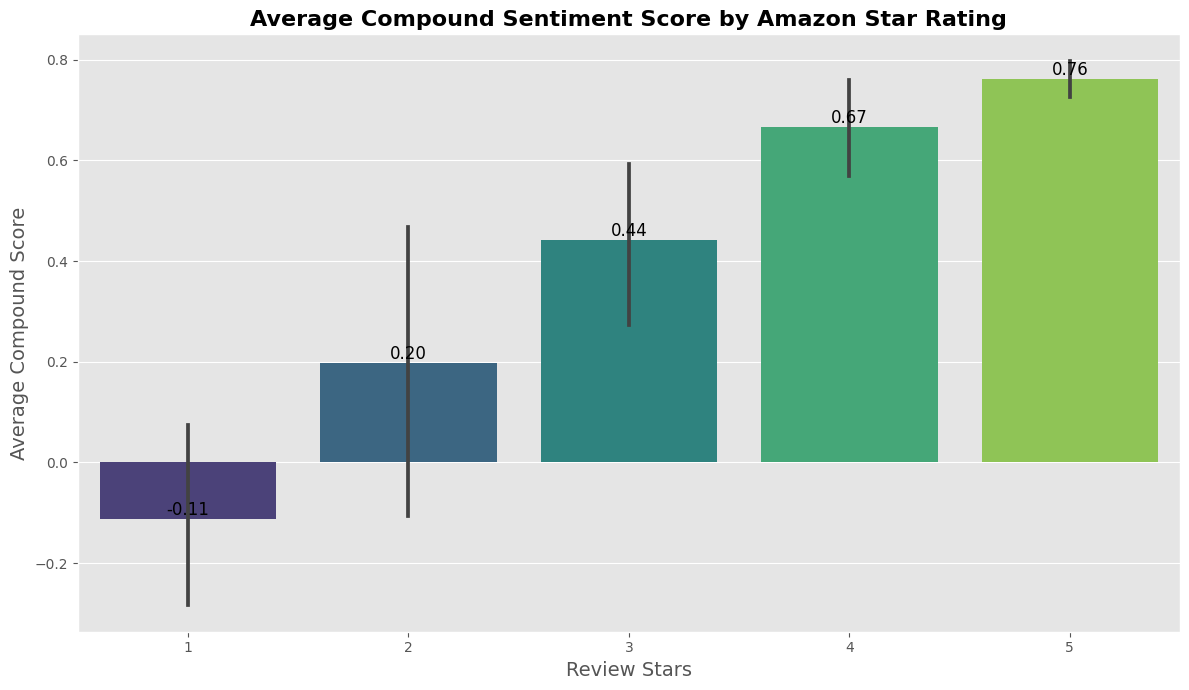

In [17]:
# Improved bar plot for compound sentiment score by review rating

# Set plot size and style
plt.figure(figsize=(12, 7))

# Create the bar plot with a descriptive color palette and enhanced annotations
ax = sns.barplot(data=vader, x='Score', y='compound', palette='viridis')
ax.set_title('Average Compound Sentiment Score by Amazon Star Rating', fontsize=16, weight='bold')
ax.set_xlabel('Review Stars', fontsize=14)
ax.set_ylabel('Average Compound Score', fontsize=14)

# Add annotations for average compound scores on each bar
for p in ax.patches:
    score = f'{p.get_height():.2f}'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(score, (x, y), ha='center', va='bottom', fontsize=12, color='black')

# Show the plot
plt.tight_layout()
plt.show()

### Analysis of Sentiment Components by Review Score

In this analysis, we explore the relationship between review scores (1 to 5 stars) and the individual sentiment components (positive, neutral, and negative) provided by VADER's sentiment analysis.

### Key Observations:

1. **Positive Sentiment**:
   Higher star ratings are associated with a higher positive sentiment score. This indicates that as the star rating increases (from 1 to 5 stars), the text of the review generally contains more positive expressions. This aligns with expectations, as higher-rated reviews are often written by satisfied customers who use positive language.

2. **Neutral Sentiment**:
   The neutral sentiment score tends to remain relatively stable across different star ratings. This shows that regardless of the star rating, reviews often contain some neutral expressions or factual information that doesn’t directly convey positive or negative sentiment. 

3. **Negative Sentiment**:
   Lower star ratings are associated with a higher negative sentiment score. This suggests that as the star rating decreases (approaching 1 star), the text of the review contains more negative expressions, which is typical of dissatisfied customers expressing complaints or criticisms.

### Visualization:

The set of bar plots below illustrates the average positive, neutral, and negative sentiment scores for each star rating. These three visualizations provide a detailed look at how different sentiment components vary with review scores, giving insight into the overall tone of reviews across different ratings.

By breaking down the compound score into its components, we gain a nuanced view of customer sentiment, helping us understand not only the overall positivity or negativity of reviews but also the balance of neutral expressions.

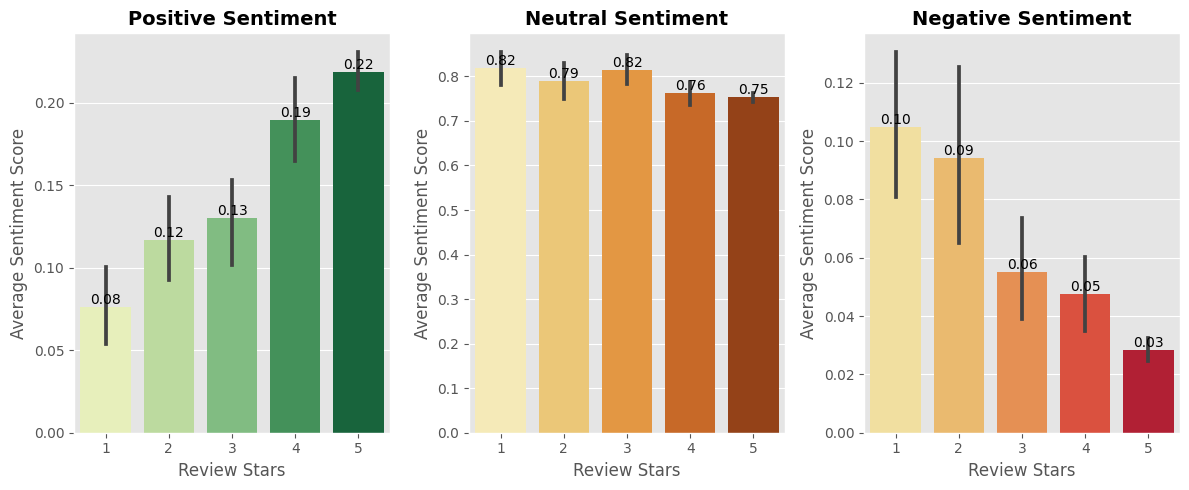

In [18]:
# Set up the figure with three subplots for positive, neutral, and negative sentiment
fig, ax = plt.subplots(1, 3, figsize=(12, 5))

# Define sentiment types, titles, and improved color palettes
sentiments = ['pos', 'neu', 'neg']
titles = ['Positive Sentiment', 'Neutral Sentiment', 'Negative Sentiment']
colors = ['YlGn', 'YlOrBr', 'YlOrRd']  # Bright, contrasting colors for better visibility

# Loop through each sentiment to create a separate bar plot in each subplot
for i, sentiment in enumerate(sentiments):
    sns.barplot(data=vader, x='Score', y=sentiment, ax=ax[i], palette=colors[i])
    ax[i].set_title(titles[i], fontsize=14, weight='bold')
    ax[i].set_xlabel('Review Stars', fontsize=12)
    ax[i].set_ylabel('Average Sentiment Score', fontsize=12)
    
    # Add data labels above each bar for clarity
    for p in ax[i].patches:
        score = f'{p.get_height():.2f}'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax[i].annotate(score, (x, y), ha='center', va='bottom', fontsize=10, color='black')

# Adjust layout for readability
plt.tight_layout()
plt.show()

## Step 3: Using a Transformer Model for Sentiment Analysis with Contextual Understanding

In this step, we enhance our sentiment analysis by leveraging a **pretrained transformer model**, specifically the **RoBERTa** model. Unlike VADER, which uses a "bag of words" approach and only considers individual words, RoBERTa captures the context and relationships between words, providing a more nuanced understanding of sentiment, especially for complex texts.

### Explanation of the Code and Process

1. **Loading the RoBERTa Model**:
   We initialize the RoBERTa model for sentiment analysis using the Hugging Face Transformers library. The specific model used is `cardiffnlp/twitter-roberta-base-sentiment`, which is trained on a large dataset of Twitter data and is effective for capturing sentiment within context. 
   
   - `AutoTokenizer`: Tokenizes the input text, breaking it into the format required by RoBERTa.
   - `AutoModelForSequenceClassification`: Loads the pretrained model for sequence classification, allowing us to analyze the sentiment of text inputs.

2. **Defining a Function for RoBERTa Sentiment Scoring**:
   The function `polarity_scores_roberta` processes a single review with the RoBERTa model:
   - It tokenizes the input text and passes it through the model.
   - The output scores are obtained and converted to probabilities using the softmax function.
   - These scores are stored in a dictionary with keys indicating negative (`roberta_neg`), neutral (`roberta_neu`), and positive (`roberta_pos`) sentiment scores.

3. **Running Sentiment Analysis on the Entire Dataset**:
   Using a loop with `tqdm` for progress tracking, we process each review in the dataset with both VADER and RoBERTa. For each review:
   - **VADER Sentiment Analysis**: We apply VADER's `polarity_scores` method to obtain `neg`, `neu`, `pos`, and `compound` scores.
   - **RoBERTa Sentiment Analysis**: We apply the `polarity_scores_roberta` function to get context-aware sentiment scores.
   - Both results are merged into a combined dictionary for each review, storing the VADER scores with a prefix (`vader_`) and the RoBERTa scores with a prefix (`roberta_`).

4. **Organizing the Results**:
   - The sentiment results for each review are stored in a dictionary called `result`, where each entry is identified by a unique review ID.
   - This dictionary is converted into a DataFrame for easier analysis and merged with the original dataset, allowing us to view the text, star rating, VADER sentiment scores, and RoBERTa sentiment scores side by side.

### Summary of Output

The resulting `result_df` DataFrame contains:
- The original text and metadata (e.g., review ID and star rating).
- **VADER Sentiment Scores** (`vader_neg`, `vader_neu`, `vader_pos`, `vader_compound`): Provides quick, word-based sentiment analysis.
- **RoBERTa Sentiment Scores** (`roberta_neg`, `roberta_neu`, `roberta_pos`): Provides context-sensitive sentiment analysis, allowing for a more accurate understanding of the sentiment.

By combining VADER and RoBERTa, we can compare the results from a simple "bag of words" approach with those from a context-aware model. This comparison provides insights into the effectiveness of each method and allows us to determine which approach aligns better with human interpretation in different types of reviews.


In [19]:
# Load the pretrained RoBERTa model and tokenizer for sentiment analysis
MODEL = 'cardiffnlp/twitter-roberta-base-sentiment'
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [20]:
# Example VADER sentiment analysis on a sample text
# Prints VADER sentiment scores (neg, neu, pos, compound) for comparison
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [21]:
# Set device to GPU if available, else use CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Move the model to the specified device (GPU or CPU)
model.to(device)

# Function to get RoBERTa sentiment scores with GPU support
def polarity_scores_roberta(example):
    # Tokenize and move the input to the same device as the model
    encoded_text = tokenizer(example, return_tensors='pt').to(device)  # Tokenize and send to device
    output = model(**encoded_text)  # Run the model on the specified device
    scores = output[0][0].detach().cpu().numpy()  # Move output back to CPU for further processing
    scores = softmax(scores)  # Apply softmax to get probabilities

    # Store scores in a dictionary with descriptive keys
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    }
    return scores_dict

Using device: cuda:0


In [22]:
# Run sentiment analysis on the entire dataset, storing error IDs in a list
error_ids = []
result = {}

for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']  # Extract the review text
        my_id = row['Id']   # Extract the unique review ID
        
        # Get VADER sentiment scores and prefix with "vader_" to distinguish from RoBERTa
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {f'vader_{key}': value for key, value in vader_result.items()}
        
        # Get RoBERTa sentiment scores
        roberta_result = polarity_scores_roberta(text)
        
        # Merge VADER and RoBERTa results into a single dictionary for this review
        both_dict = {**vader_result_rename, **roberta_result}
        
        # Store the combined results in the result dictionary with the review ID as the key
        result[my_id] = both_dict
    except RuntimeError:
        # Append the error ID to the list
        error_ids.append(my_id)

  0%|          | 0/500 [00:00<?, ?it/s]

In [23]:
# Convert the list of error IDs to a DataFrame
error_df = pd.DataFrame(error_ids, columns=['Error_IDs'])

# Display the DataFrame
# error_df

In [24]:
# Convert the results dictionary to a DataFrame
# Transpose the DataFrame so each row corresponds to a review and reset the index
result_df = pd.DataFrame(result).T
result_df = result_df.reset_index().rename(columns={'index': 'Id'})

# Merge the sentiment scores DataFrame with the original dataset based on the 'Id' column
# This adds sentiment scores (from both VADER and RoBERTa) alongside the original review data
result_df = result_df.merge(df, how='left', on='Id')

# Display the first few rows of the merged DataFrame for inspection
result_df.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.079,0.853,0.068,-0.1027,0.508986,0.452413,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Comparison of VADER and RoBERTa Sentiment Analysis Models

### 1. **Introduction**
   - **VADER (Valence Aware Dictionary and Sentiment Reasoner)**: A rule-based sentiment analysis model that scores text based on a predefined sentiment dictionary, suitable for social media and customer reviews.
   - **RoBERTa**: A transformer-based model fine-tuned for sentiment analysis, capable of understanding context, making it powerful for capturing nuanced sentiments.

### 2. **Methodology**

### VADER Sentiment Scoring
   - Initializes the `SentimentIntensityAnalyzer` to generate scores based on a "bag of words" approach.
   - Scores include:
     - **neg**: Probability of negative sentiment.
     - **neu**: Probability of neutral sentiment.
     - **pos**: Probability of positive sentiment.
     - **compound**: Overall sentiment score ranging from -1 (most negative) to +1 (most positive).
   - Outputs a DataFrame with sentiment scores for each review.

### RoBERTa Sentiment Scoring
   - Uses a pre-trained model (`cardiffnlp/twitter-roberta-base-sentiment`) via Hugging Face, capturing context within sentences.
   - Generates **negative**, **neutral**, and **positive** probabilities for each text sample.
   - Scores are combined with VADER’s scores for comparison in a unified DataFrame.

### 3. **Comparison Criteria**
   - **Accuracy**: How well each model aligns with review star ratings.
   - **Context Sensitivity**: Ability to capture nuances in sentiment (e.g., sarcasm or contextual implications).
   - **Speed and Efficiency**: Comparing processing time, especially on large datasets.

### 4. **Analysis and Observations**
   - **Correlation with Ratings**: Higher star ratings generally yield positive VADER and RoBERTa scores.
   - **Differences in Compound Scoring**:
     - VADER’s simple scoring method may overlook nuanced phrases.
     - RoBERTa’s context sensitivity provides more accurate scoring for complex sentiments.
   - **Error Analysis**: Identifies cases where the models diverge significantly in sentiment classification.

### 5. **Visualization**
   - **Bar Plot of Compound Scores** by Review Rating: Illustrates how each model’s scores vary by star rating.
   - **Sentiment Component Comparison**: Breaks down positive, neutral, and negative scores, showing how they change with ratings.

### 6. **Conclusion**
   - **VADER**: Fast, efficient, and suitable for straightforward text but limited in handling complex contexts.
   - **RoBERTa**: More accurate for context-rich reviews, but computationally intensive, making it suitable for in-depth analysis.


<Figure size 1200x800 with 0 Axes>

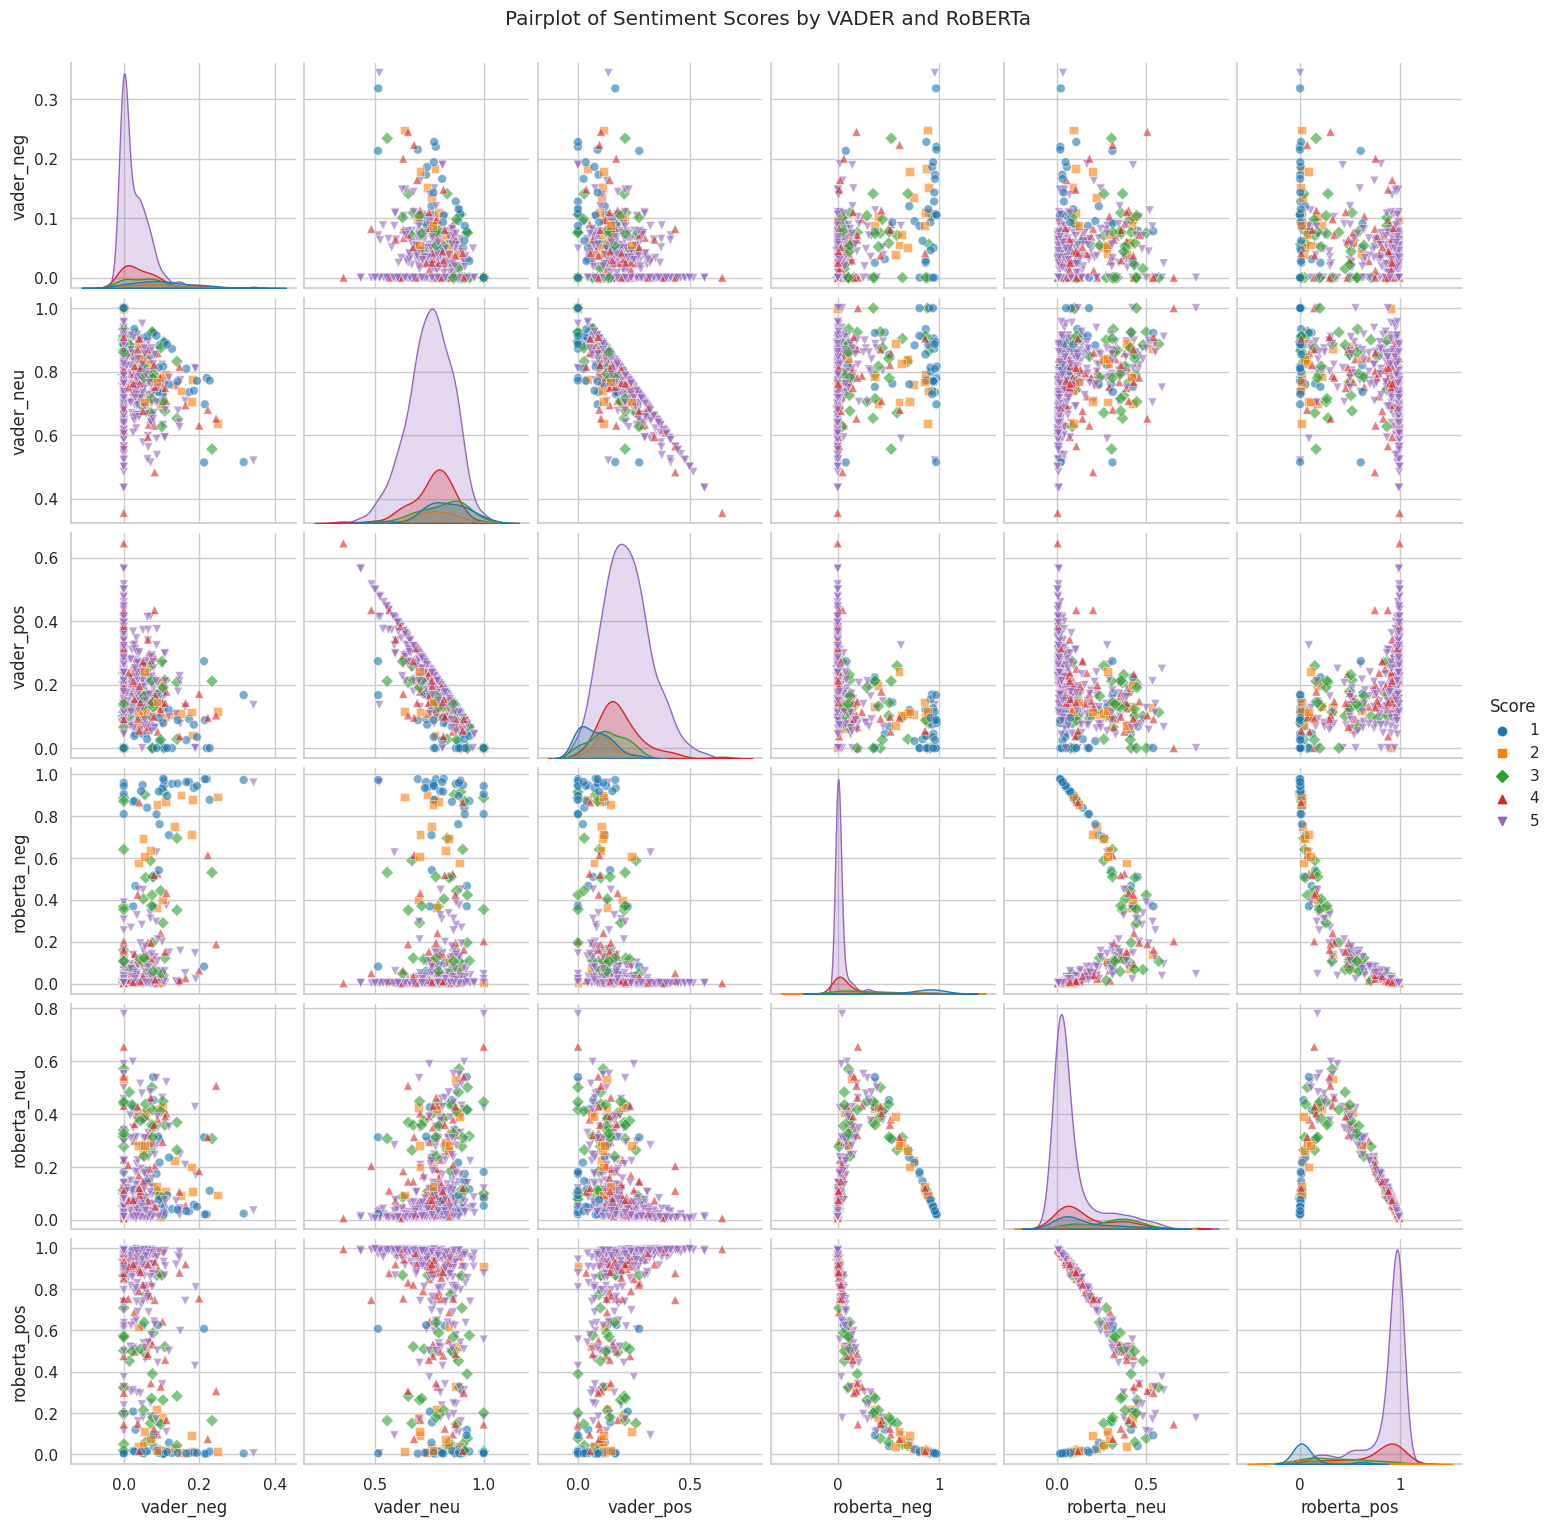

In [25]:
# Replace inf values with NaN
result_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Suppress specific FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Get unique values from 'Score' column
unique_scores = result_df['Score'].nunique()

# Generate a list of markers matching the number of unique scores
marker_styles = ['o', 's', 'D', '^', 'v', 'P', '*', 'X', 'H', '8']  # Extend as needed
markers = marker_styles[:unique_scores]

# Set the size and style of the plot
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Create the pairplot with the dynamically defined markers
pairplot = sns.pairplot(
    data=result_df,
    vars=['vader_neg', 'vader_neu', 'vader_pos', 'roberta_neg', 'roberta_neu', 'roberta_pos'],
    hue='Score',                      # Color by the 'Score' column
    palette='tab10',                   # Use a distinct color palette
    markers=markers,                   # Dynamically generated markers
    plot_kws={'alpha': 0.6, 's': 40}   # Set transparency and marker size
)

# Add a title for context
pairplot.fig.suptitle('Pairplot of Sentiment Scores by VADER and RoBERTa', y=1.02)

# Show the plot
plt.show()

## Step 4: Review Example

### Positive 1-Star and Negative 5-Star Reviews
To better understand the model's performance, let's examine some examples where there is a significant difference between the model's sentiment scores and the actual review star ratings.

In these cases:
- **Positive 1-Star Review**: This might occur if a review has a low star rating but uses words or phrases that the model interprets as positive (e.g., sarcasm or unintended positivity).
- **Negative 5-Star Review**: This can happen if a high-rating review includes words that convey dissatisfaction or criticism, confusing the sentiment model.

Analyzing these discrepancies helps us identify areas where the model may misinterpret sentiment due to nuances, sarcasm, or complex language. By studying these examples, we can refine the model to handle these types of challenging cases better.


In [26]:
# Get the text of the row with the highest 'roberta_pos' score where 'Score' is 1
result_df.loc[result_df.query('Score == 1')['roberta_pos'].idxmax(), 'Text']

'I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money.'

In [27]:
# Get the text of the row with the highest 'vader_pos' score where 'Score' is 1
text_high_vader_pos_score_1 = result_df.loc[result_df.query('Score == 1')['vader_pos'].idxmax(), 'Text']
text_high_vader_pos_score_1

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

The VADER model, like other "bag of words" models, has difficulty detecting sarcasm because it processes words individually and assigns sentiment scores without considering the broader context or relationships between words.

### Detailed Explanation

- **Bag of Words Approach**: VADER uses a "bag of words" method, analyzing words in isolation and ignoring their order or interaction. Each word has a predefined sentiment score (positive, negative, or neutral) based solely on its appearance.

- **Lack of Contextual Understanding**: Since VADER doesn’t analyze sentence structure or word relationships, it struggles with sentences where words convey different meanings depending on context, such as sarcasm or irony.
  - **Example of Sarcasm**: In a sentence like "Oh great, another delay," the word "great" usually conveys a positive sentiment. VADER would likely interpret this as positive, missing the sarcastic tone that actually implies frustration or negativity.

- **Impact on Sentiment Scoring**: Due to this limitation, VADER may misclassify texts that rely on sarcasm or nuanced language, as it cannot infer the implied sentiment from context alone.

In contrast, transformer-based models like **RoBERTa** analyze relationships between words and capture nuances, making them more effective for understanding sarcasm and complex sentiment.
* Like vader model, will not pickup the sarcastic in the model since it is only look for the bag of word and put a vlue to it

In [28]:
text_high_roberta_pos_score_5 = result_df.loc[result_df.query('Score == 5')['roberta_pos'].idxmax(), 'Text']
text_high_roberta_pos_score_5

"These are my favorite bars ever. The combo of raisons and dark choc is wonderful! Very filling! These are hard to find in the stores. I'm thankful for subsrcibe and save!"

In [29]:
# Get the text of the row with the highest 'vader_pos' score where 'Score' is 5
text_high_vader_pos_score_5 = result_df.loc[result_df.query('Score == 5')['vader_pos'].idxmax(), 'Text']
text_high_vader_pos_score_5

'This is an great product. The taste is great, and it works exactly as described. Superb natural sleep aid. AMAZING!'

## Extra: The Transformer Pipeline from Hugging Face

The Hugging Face `pipeline` provides a quick and easy way to perform various natural language processing (NLP) tasks, including sentiment prediction, using pre-trained transformer models. This pipeline simplifies the process, so you can run predictions with just a few lines of code without needing to manage the details of loading models and tokenizers manually.

In [30]:
from transformers import pipeline

# Initialize the sentiment analysis pipeline with a specific pre-trained model
# 'distilbert/distilbert-base-uncased-finetuned-sst-2-english' is the current default model for sentiment analysis.
# Specifying it explicitly ensures the same model version is used consistently.
sentiment_pipeline = pipeline(
    'sentiment-analysis', 
    model='distilbert/distilbert-base-uncased-finetuned-sst-2-english', 
    revision='714eb0f',  # Explicitly specifying the model revision to ensure consistency
    device=0  # Use GPU if available, otherwise set device=-1 for CPU
)

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [31]:
# Run sentiment analysis on a sample text
# This line uses the initialized sentiment pipeline to predict the sentiment of the input text.
# The `pipeline` function will output a list of dictionaries, where each dictionary contains:
# - 'label': The predicted sentiment label (e.g., 'POSITIVE' or 'NEGATIVE')
# - 'score': The confidence score associated with the predicted label, between 0 and 1

result = sentiment_pipeline('I love sentiment analysis')

# Display the result
result

[{'label': 'POSITIVE', 'score': 0.999736487865448}]

In [32]:
result = sentiment_pipeline('Boo')

# Display the result
result

[{'label': 'NEGATIVE', 'score': 0.9715901017189026}]